# TP2 INF889G - Vision par ordinateur H24

Autheurs 

- François Huppé-Marcoux (HUPF10049509)

- Guillaume Carignan (CARG29099504)

Github link : https://github.com/FrancoisHUP/TP2_INF889G/

## Setup 

Ces ligne serve au developpement dans une notebook pour actualiser les imports de librairie. 

In [7]:
# Load and enable the autoreload extension
%load_ext autoreload
%autoreload 2

Télécharger les images 

In [1]:
# Pull data from github
import os
import requests

urls = [
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier1.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier2.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier3.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier4.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier5.png',
  'https://raw.githubusercontent.com/FrancoisHUP/TP2_INF889G/main/data/Rainier6.png',
]

# create data rep
if not os.path.exists('data'):
    os.makedirs('data')

# download images
for url in urls:
  r = requests.get(url)
  filename = url.split('/')[-1]
  with open('data/' + filename, 'wb') as f:
      f.write(r.content)

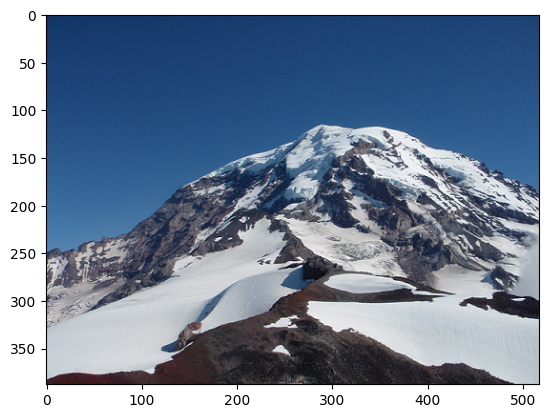

In [1]:
# plot image
import matplotlib.pyplot as plt
from PIL import Image

im=Image.open('data/Rainier1.png')
plt.imshow(im)
plt.show()

## Panorama

### Detection des coins de harris

#### Installation

Installer Cv2

In [3]:
# Instal CV2
!pip install opencv-python imageio > /dev/null && echo "Installation completed!" || echo "Installation failed!"

"Installation completed!" 



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\frank\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Importer l'image

In [4]:
# Import img
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image (Change 'image_path.jpg' to your image file)
image = cv2.imread('data/Rainier1.png')

# Convert BGR image to RGB for correct color plotting
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

#### Implémentation

Voici la démarche pour implémenter le  [détecteur de Harris](https://bmva-archive.org.uk/bmvc/1988/avc-88-023.pdf).

1. Calcule du tenseur de structure 

Calcul du tenseur de structure d'une image. Ce tenseur est une représentation 
de la structure locale de l'image en termes de gradients. Pour le calculer, on 
calcule les dérivées en x et y avec le filtre de Sobel. Ensuite, on applique un 
filtre gaussien pour adoucir les contours. La formule à appliquer est la suivante :

$$ E(u, v) = \sum_{x,y} w(x, y) \left[ I(x + u, y + v) - I(x, y) \right]^2 $$

(388, 517, 3)


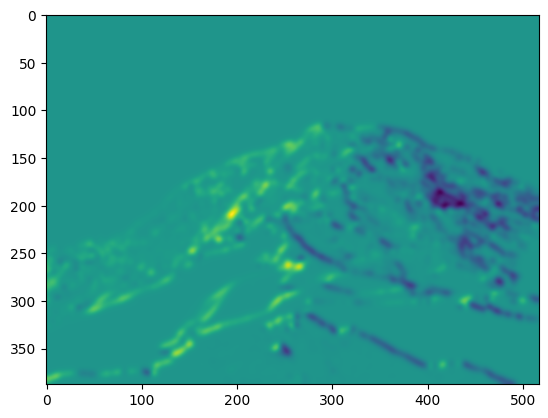

In [5]:
from harris_image import structure_matrix

S = structure_matrix(gray, 3) 

print(S.shape)

plt.imshow(S[:,:,2])
plt.show()

2. Calcule de la similarité à un coin

Estime les caractéristiques d'un coin de chaque pixel dans une image en utilisant le tenseur de structure de l'image. Le tenseur de structure encapsule des informations locales sur la direction et l'intensité des gradients d'une image, permettant de détecter des caractéristiques importantes comme les coins. Les formules à appliquer est la suivante :


$$ M = \sum_{x,y} w(x, y)
\begin{bmatrix}
I_x I_x & I_x I_y \\
I_x I_y & I_y I_y 
\end{bmatrix} $$
$$ R = \det(M) - k(\text{trace}(M))^2 $$

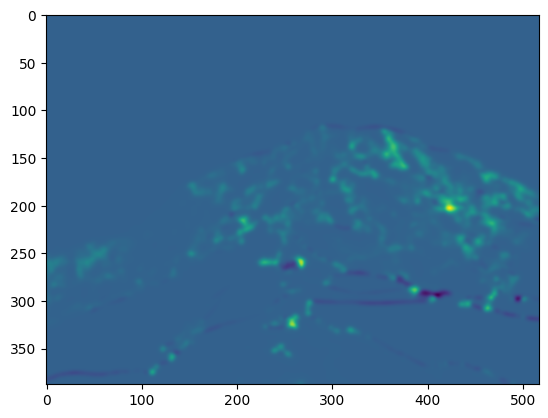

In [7]:
from harris_image import cornerness_response

R = cornerness_response(S) 

plt.imshow(R)
plt.show()

3. Suppression des non-maximum

La fonction identifie et conserve uniquement les points forts (maximums locaux) dans une image.

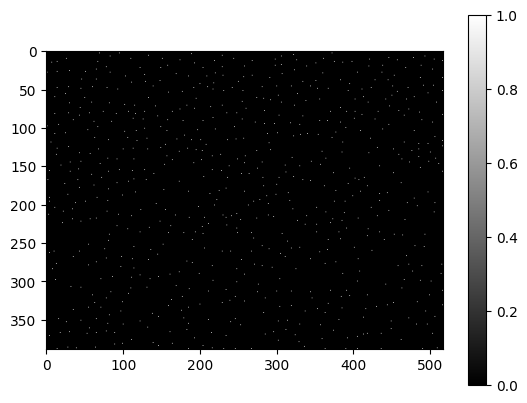

In [9]:
from harris_image import nms_image
Rnms = nms_image(R, 3) 

plt.imshow(np.where(Rnms == -np.inf, 0, 1), cmap='gray')  
plt.colorbar()  
plt.show()

En somme, "detect_and_draw_corners" applique des filtres pour trouver les points des coins les plus caractéristiques qui serviront au recalage d'image dans un panorama. On peut voir les coins sélectionnés avec un croix mauve.


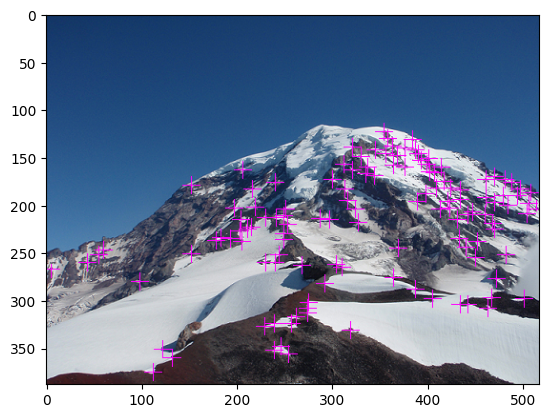

In [28]:
import imageio
import matplotlib.pyplot as plt
from harris_image import detect_and_draw_corners
    
sigma=2; thresh=0.3; nms=3
im = imageio.v2.imread("data/Rainier1.png")
im_cd = detect_and_draw_corners(im, sigma, thresh, nms)
plt.imshow(im_cd); plt.show()

### Correspondance des patchs

Pour les prochaines sections, nous allons mettre en place les fonction necessaire a l'algorithe [RANdom SAmple Consensus (RANSAC)](http://www.cse.yorku.ca/~kosta/CompVis_Notes/ransac.pdf).  


1. Métrique de distance 

In [26]:
from panorama_image import l1_distance 

d = l1_distance(np.array([1, 2]), np.array([3, 4]))

print(d)
assert d == 4

4


2. Pairage des descripteurs

On obtient des coins avec leur descripteur. Il faut maintenant apparier les descripteurs entre eux pour avoir une relation de un à un. On utilise le voisinage de chaque point et on compare les intensités. Deux coins avec des intensités semblables auront une distance plus petite et seront considérés comme équivalents dans les deux images.

- 2.1. Détection du meilleur pairage de a vers b 

- 2.2. Éliminer les patchs multiples pour un même descripteur

Nombre de point trouvé avec un : 43
Plus petit distance : 685.0, Plus grand distance : 3955.0


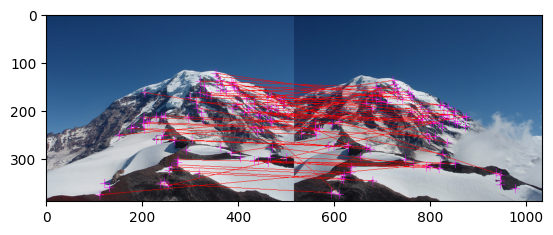

In [31]:
from panorama_image import match_descriptors, harris_corner_detector, find_and_draw_matches
import imageio

a = imageio.v2.imread("data/Rainier1.png")
b = imageio.v2.imread("data/Rainier2.png")
ad = harris_corner_detector(a, 2, 0.5, 3)
bd = harris_corner_detector(b, 2, 0.5, 3)

m = match_descriptors(ad,bd)
print(f"Nombre de point trouvé avec un : {len(m)}") 
print(f"Plus petit distance : {min(item['distance'] for item in m)}, Plus grand distance : {max(item['distance'] for item in m)}") 

m = find_and_draw_matches(a,b,sigma=2,thresh=0.4,nms=3)
plt.imshow(m); plt.show()


3. Ajouter la projection aux données


- 3.1 Projection des points par homographie

La projection sera utile pour recaler des images l'une sur l'autre. Pour l'affichage, on utilise la fonction warpPerspective pour déplacer l'image dans l'espace. Un peu plus tard, nous allons utiliser notre propre fonction pour recaler l'image.

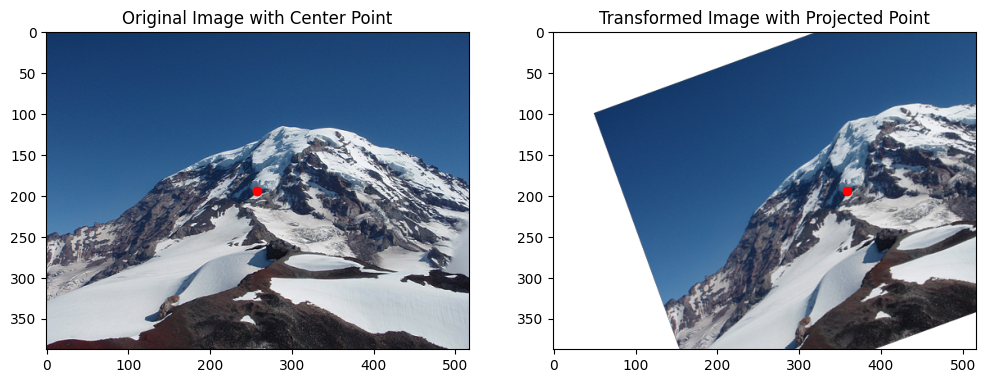

In [34]:

from panorama_image import project_point
import numpy as np
import imageio
import matplotlib.pyplot as plt
import cv2

# Load the image
a = imageio.v2.imread("data/Rainier1.png")

# For testing, we will apply a simple transformation to the image
tx, ty = 50, 100  # Translation
theta = np.radians(-20)  # Rotation angle in radians for z-axis rotation

# Construct the homography matrix for rotation around the z-axis and translation
H = np.array([
    [np.cos(theta), -np.sin(theta), tx],
    [np.sin(theta), np.cos(theta), ty],
    [0, 0, 1]
])

# Project the center point of image a using the homography
center_point = [a.shape[1] // 2, a.shape[0] // 2] 
projected_center = project_point(H, center_point)

# Apply the transformation to the image
transformed_image = cv2.warpPerspective(a, H, (a.shape[1], a.shape[0]))

# Display the original and transformed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(a)
ax[0].plot(center_point[0], center_point[1], 'ro')  
ax[0].set_title('Original Image with Center Point')

ax[1].imshow(transformed_image)
ax[1].plot(projected_center[0], projected_center[1], 'ro') 
ax[1].set_title('Transformed Image with Projected Point')

plt.show()
                   

- 3.2 Calcule de la distance entre deux points (Distance euclédienne)

In [5]:
from panorama_image import point_distance

d = point_distance(np.array([1, 1]), np.array([1, 3]))

assert d == 2
print(d)

2.0


- 3.3 Calcule les inliner d'un modèle 

On obtient deux images et leur coin correspondant. Dans cette section, on cherche à trouver les inliers d'une transformation H de l'image. Les inliers correspondent aux points de l'image qui sont bien placés après la transformation H.

Pour tester on prend une matrice de transformation identitaire et on augmente le seuil pour le inlier (pour avoir au moin 1 inlier). 


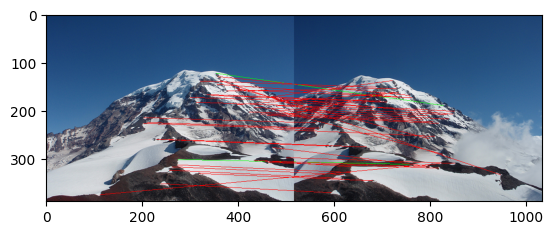

In [35]:
from panorama_image import draw_inliers, harris_corner_detector, match_descriptors
import imageio
import numpy as np
import matplotlib.pyplot as plt


sigma=2; thresh=0.5; nms=3; inlier_thresh=100; theta=0; tx=0; ty=0
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

# Use the identity matrix as the homography matrix for testing
H = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

out = draw_inliers(a, b, H, matches, inlier_thresh)
plt.imshow(out); plt.show()

- 3.4  Ajuster l'homographie

Ici, on calcule la transformation à faire selon des matchs $m_{x} m_{y}$ $n_{x} n_{y}$. On cherche a trouver la matrice homographique de la transformation d'un point $m$ à un point $n$  Il faut résoudre cette équation et trouver la matrice $A$:

$$ Ma = b $$

\begin{equation}
\begin{bmatrix}
m_{x1} & m_{y1} & 1 & 0 & 0 & 0 & -m_{x1}n_{x1} & -m_{y1}n_{x1}\\
0 & 0 & 0 & m_{x1} & m_{y1} & 1 & -m_{x1}n_{y1} & -m_{y1}n_{y1}\\
m_{x2} & m_{y2} & 1 & 0 & 0 & 0 & -m_{x2}n_{x2} & -m_{y2}n_{x2}\\
0 & 0 & 0 & m_{x2} & m_{y2} & 1 & -m_{x2}n_{y2} & -m_{y2}n_{y2}\\
m_{x3} & m_{y3} & 1 & 0 & 0 & 0 & -m_{x3}n_{x3} & -m_{y3}n_{x3}\\
0 & 0 & 0 & m_{x3} & m_{y3} & 1 & -m_{x3}n_{y3} & -m_{y3}n_{y3}\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{bmatrix}
\begin{bmatrix}
a_{00} \\
a_{01} \\
a_{02} \\
a_{10} \\
a_{11} \\
a_{12}
\end{bmatrix}
=
\begin{bmatrix}
n_{x1} \\
n_{y1} \\
n_{x2} \\
n_{y2} \\
n_{x3} \\
n_{y3} \\
\vdots
\end{bmatrix}
\end{equation}

In [24]:
from panorama_image import compute_homography, harris_corner_detector, match_descriptors
import numpy as np
import imageio

sigma=2; thresh=0.5; nms=3; 
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

H = compute_homography(matches, 5) 
print("H :", H)



H : [[ 1.15210654e+00  1.43330770e-01 -2.97137866e+01]
 [-4.29203327e-02  1.25389289e+00 -1.97707608e+02]
 [-5.47245147e-05  5.19877984e-04  1.00000000e+00]]


4. Correspondance aléatoire

In [5]:
from panorama_image import randomize_matches, harris_corner_detector, match_descriptors
import imageio

sigma=2; thresh=0.5; nms=3
a = imageio.v2.imread("data/Rainier1.png");b = imageio.v2.imread("data/Rainier2.png")

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
matches = match_descriptors(ad, bd)

# For demonstration purposes, we set id for each match
matches = [{"id": i, "match": m} for i, m in enumerate(matches)]

# Lets randomize the best 10 matches
shuffle = randomize_matches(matches)
print("Entre deux executions, les ids des points changent")
print([m["id"] for m in matches])

Entre deux executions, les ids des points changent
[38, 15, 5, 19, 42, 33, 1, 11, 22, 30, 39, 0, 10, 16, 6, 23, 2, 3, 7, 34, 8, 27, 41, 12, 31, 28, 9, 26, 18, 20, 24, 4, 37, 25, 13, 14, 17, 21, 35, 32, 29, 36, 40]


### Implémenter RANSAC



On obtient des correspondances entre deux images (coordonnées x,y qui sont les plus pertinentes - qui se démarquent le plus des autres segments de l'image). Les correspondances sont calculées avec une distance $L1$ et elles sont imparfaites. À partir de ces correspondances, on essaie de trouver la meilleure combinaison de correspondances.

Pour ce faire, on utilise l'algorithme RANSAC qui consiste à :

1. Randomiser les correspondances.

2. Calculer la matrice de transformation pour ces correspondances (Cette matrice de transformation permet de recaler les images dans un même espace de coordonnées).

3. Compter les inliers. Avec les transformations superposées de l'image, on recalcule la distance $L2$ pour chacun des points. Ceux qui ont une distance en dessous d'un seuil, on les additionne comme inliers (correctement superposés selon l'algorithme) et le reste en outliers.

La combinaison de randomisation des correspondances et la superposition des images qui obtient le plus d'inliers sera prise comme meilleure transformation et considérée comme solution optimale au système d'équations.

In [7]:
from panorama_image import RANSAC

# added a parameter to the RANSAC function 
a; b; sigma=2; thresh=0.4; nms=3; inlier_thresh=2; iters=5000; cutoff=5

# Calculate corners and descriptors
ad = harris_corner_detector(a, sigma, thresh, nms)
bd = harris_corner_detector(b, sigma, thresh, nms)

# Find matches
m = match_descriptors(ad, bd)

# Run RANSAC to find the homography
H = RANSAC(m, inlier_thresh, iters, cutoff)

print(f"Meilleure homographie trouve avec les parametres inlier_thresh={inlier_thresh} iters={iters} cutoff={cutoff}:")
print(H)

Meilleure homographie trouve avec les parametres inlier_thresh=2 iters=5000 cutoff=5:
[[ 8.90917056e-01  1.24126492e-02  2.16759369e+01]
 [-1.70105237e-01  9.92674379e-01 -1.28446256e+02]
 [-2.51304388e-04  1.29078988e-05  1.00000000e+00]]


### Combiner les images avec l'homographie

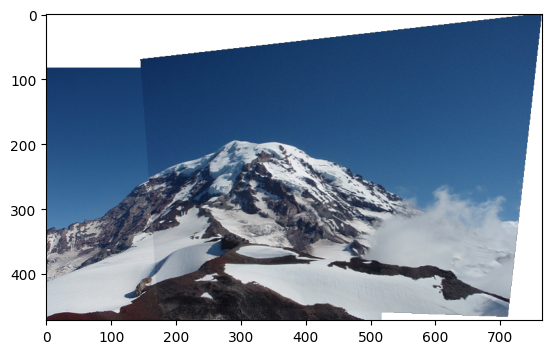

In [6]:
import imageio
import matplotlib.pyplot as plt
from panorama_image import panorama_image

im1 = imageio.v2.imread("data/Rainier1.png")
im2 = imageio.v2.imread("data/Rainier2.png")
pan = panorama_image(im1, im2, sigma=2, thresh=0.4, nms=3, inlier_thresh=2, iters=5000, cutoff=100)
plt.imshow(pan); plt.show()

#### Analyse 

Notre résultat est satisfaisant mais n'est pas parfait. Nous avons testé avec bon nombre de combinaisons de *threshold*, *inlier_thresh* et *cutoff* et ce, avec plusieurs choix de nombre d'itérations. Les meilleurs résultats sont ceux avec un *threshold* et *inlier_thresh* bas ainsi qu'un *cutoff* assez haut.
 Il semble que notre implémentation du panorama projectif a des lacunes qui se situent peut-être dans les limitaions que nous nous sommes imposés pour suivre les étapes du travail. Cela peut venir de nos descripteurs ou de notre combinaison des deux images (nous n'utilisons jamais *theta* dans cette implémentation). Nous nous sommes aussi limités aux indications des fonctions implémentées/semi-implémentées pour nos valeurs de paramètres ce qui a pu jouer en notre défaveur.